In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(12, 12)


import geopandas as gpd
import pandas as pd
import rasterio as rio

from rasterio import plot as rio_plot

# HRSL Spike

**Note: This data is all compressed on S3 so you will need to unzip both the GADM data (shapefiles of political boundaries) and the HRSL data (raster grids of population) before running this notebook.**

 - Load Admin2 boundaries from GADM
 - Select Rawanda as a test case
 - plot the boundaries
 - plot all the data
 - Calculate the sum per admin area using `zonal_stats`
 - plot the calculated populations
 

### Load GADM boundaries

In [2]:
boundaries = gpd.read_file(str(Path('../data/external/gadm28_levels.shp/gadm28_adm2.shp')))

In [3]:
rwa_admin_2 = boundaries[boundaries.ISO == 'RWA']

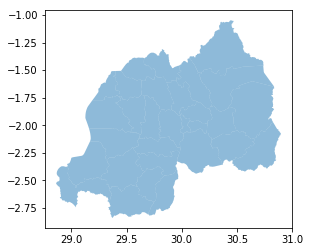

In [4]:
rwa_admin_2.plot(alpha=0.5)

### Load HRSL data

In [5]:
rwa_hrsl_path = str(Path("../data/external/HRSL/rwa/hrsl_rwa.tif"))
rst = rio.open(rwa_hrsl_path)

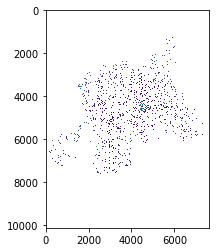

In [6]:
rio_plot.show(rst, cmap=plt.cm.viridis)

### Calculate sum of population for each admin area

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is try

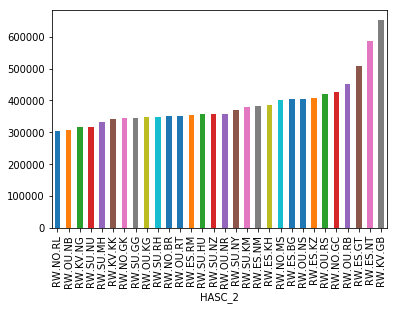

In [7]:
import rasterstats as rs

pop_list = rs.zonal_stats(rwa_admin_2, rwa_hrsl_path, stats='sum')
rwa_admin_2['hrsl_pop'] = [x['sum'] for x in pop_list]

(rwa_admin_2.set_index('HASC_2')
            .hrsl_pop
            .sort_values()
            .plot(kind='bar'))

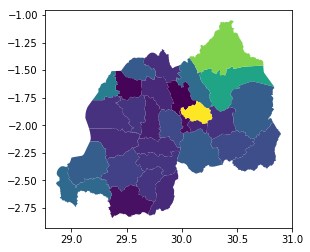

In [8]:
rwa_admin_2.plot(column='hrsl_pop')

# Load World Pop Births

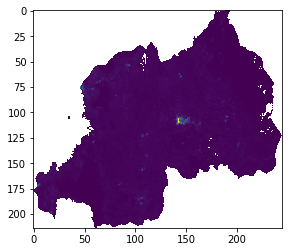

In [9]:
# rwa_worldpop_births_path = str(Path("/Users/bull/Downloads/Rwanda 1km births/RWA_births_pp_v2_2015.tif"))
rwa_worldpop_births_path = str(Path("../data/external/WorldPop/Rwanda 1km births/RWA_births_pp_v2_2015.tif"))


rst = rio.open(rwa_worldpop_births_path)
rio_plot.show(rst, cmap=plt.cm.viridis)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is try

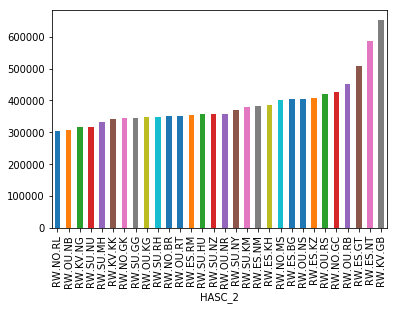

In [10]:
pop_list = rs.zonal_stats(rwa_admin_2, rwa_worldpop_births_path, stats='sum')
rwa_admin_2['worldpop_births'] = [x['sum'] for x in pop_list]

(rwa_admin_2.set_index('HASC_2')
            .hrsl_pop
            .sort_values()
            .plot(kind='bar'))

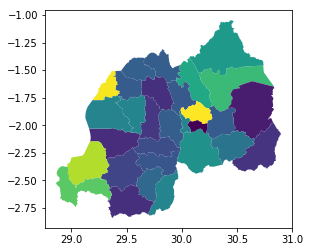

In [11]:
rwa_admin_2.plot(column='worldpop_births')

### Load WHO data

In [12]:
who_df = pd.read_csv(Path("../data/interim/calc_cols_added.csv"), index_col=0)

who_rwa = who_df[who_df['Iso Code'] == 'RWA']
who_rwa.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing
133606,RWA,Rwanda,AFRO,2016,HepB_BD,East,Bugesera District,1.0,12209.0,NaN,NaN,NaN,East - Bugesera District,rwanda,1,HepB,HepB_BD,1st_birth
133607,RWA,Rwanda,AFRO,2016,BCG,East,Bugesera District,1.0,12209.0,NaN,125.451701,15316.398164,East - Bugesera District,rwanda,1,BCG,BCG,1st_birth


### Estimate population with WHO data

 - Get denominator for each region
 - Multiply by the crude birth rate (https://data.worldbank.org/indicator/SP.DYN.CBRT.IN)
 - Remove " Distrct" from names
 - Plot estimates

In [13]:
who_rwa_births = (who_rwa[who_rwa.DenomType == 1]
                         .groupby('Admin2')
                         .Denominator
                         .first())

who_rwa_pops = who_rwa_births.multiply(1000 / 32)  # crude birth rate for rwanda

# index to names that will match admin2
who_rwa_births.index = who_rwa_births.index.str.strip(" District")
who_rwa_births.name = 'who_reported_births'

who_rwa_pops.index = who_rwa_pops.index.str.strip(" District")
who_rwa_pops.name = 'who_pop_estimate'

who_rwa_pops

Admin2
Bugesera      381531.25
Burera        354812.50
Gakenke       356562.50
Gasabo        558218.75
Gatsibo       456500.00
Gicumb        417031.25
Gisagara      339968.75
Huye          346187.50
Kamony        358937.50
Karong        349750.00
Kayonza       362781.25
Kicukiro      335781.25
Kirehe        358812.50
Muhanga       336406.25
Musanze       388218.75
Ngoma         355187.50
Ngororero     351781.25
Nyabihu       310687.50
Nyagatare     491062.50
Nyamagabe     360000.00
Nyamasheke    402500.00
Nyanza        341250.00
Nyarugenge    299968.75
Nyaruguru     310281.25
Rubavu        425531.25
Ruhango       337187.50
Rulindo       303250.00
Rusiz         422593.75
Rutsiro       342250.00
Rwamagana     330406.25
Name: who_pop_estimate, dtype: float64

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


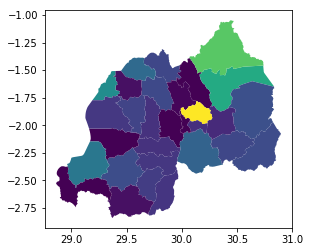

In [14]:
(rwa_admin_2.set_index('NAME_2')
            .join(who_rwa_pops)
            .plot(column='who_pop_estimate'))

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


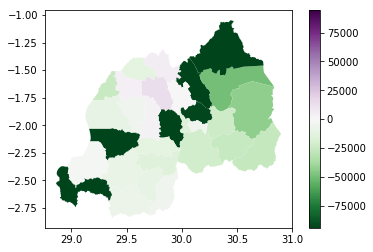

In [15]:
diff_data = (rwa_admin_2.set_index('NAME_2')
                        .join(who_rwa_pops)
                        .assign(who_diff=lambda x: x.who_pop_estimate - x.hrsl_pop))


diff_data.plot(column='who_diff',
               cmap=plt.cm.PRGn_r,
               legend=True,
               vmin=-diff_data.who_diff.abs().max(),
               vmax=diff_data.who_diff.abs().max())

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


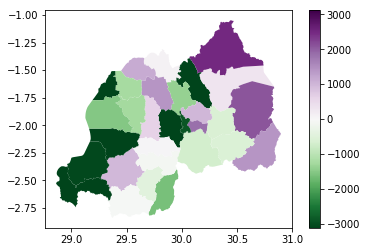

In [16]:
diff_data2 = (rwa_admin_2.set_index('NAME_2')
                        .join(who_rwa_births)
                        .assign(worldpop_diff=lambda x: x.who_reported_births - x.worldpop_births))


diff_data2.plot(column='worldpop_diff',
               cmap=plt.cm.PRGn_r,
               legend=True,
               vmin=-diff_data2.worldpop_diff.abs().max(),
               vmax=diff_data2.worldpop_diff.abs().max())

# plt.colorbar(ax=ax)

## 